# 1.5 AdventureWorks databases with Differential Privacy

In this notebook, we'll use the AdventureWorks databases which are published by Microsoft for the demonstration of SQL Server. This database contains several customer data and purchases data.

Reference: https://github.com/microsoft/sql-server-samples/tree/master/samples/databases/adventure-works/data-warehouse-install-script

*Note: This demo demonstrates the calculation of both the non-private and private results i.e., without using PyDP library and when using PyDP library, for better comparison and understanding of results.*

## Initial Settings

In [1]:
# Install the PyDP package
! pip install python-dp

In [2]:
import glob
import re
import pandas as pd
import statistics # for calculating mean without applying differential privacy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import pydp as dp # by convention our package is to be imported as dp (for Differential Privacy!)
from pydp.algorithms.laplacian import BoundedSum, BoundedMean, BoundedStandardDeviation, Count, Max, Min, Median

we'll use several cleaned tables. 

In [3]:
file_paths = glob.glob("data/*")
print(file_paths)

['data/AdventureWorks-Calendar.csv', 'data/AdventureWorks-Customers.csv', 'data/AdventureWorks-Returns.csv', 'data/AdventureWorks-Sales-2015.csv', 'data/AdventureWorks-Sales-2017.csv']


AdventureWorks-Customers.csv contains attributes of each customer. 

In [4]:
df_cus = pd.read_csv("data/AdventureWorks-Customers.csv")
print(df_cus.shape)
df_cus.head()

(18148, 13)


,CustomerKey,Prefix,FirstName,LastName,BirthDate,MaritalStatus,Gender,EmailAddress,AnnualIncome,TotalChildren,EducationLevel,Occupation,HomeOwner
0,11000,MR.,JON,YANG,04-08-1966,M,M,jon24@adventure-works.com,"$90,000",2,Bachelors,Professional,Y
1,11001,MR.,EUGENE,HUANG,5/14/1965,S,M,eugene10@adventure-works.com,"$60,000",3,Bachelors,Professional,N
2,11002,MR.,RUBEN,TORRES,08-12-1965,M,M,ruben35@adventure-works.com,"$60,000",3,Bachelors,Professional,Y
3,11003,MS.,CHRISTY,ZHU,2/15/1968,S,F,christy12@adventure-works.com,"$70,000",0,Bachelors,Professional,N
4,11004,MRS.,ELIZABETH,JOHNSON,08-08-1968,S,F,elizabeth5@adventure-works.com,"$80,000",5,Bachelors,Professional,Y


In [5]:
# convert AnnualIncome to numeric data
df_cus["AnnualIncome"] = df_cus["AnnualIncome"].apply(lambda x: int(re.sub(r"[^0-9]", "", x)))
df_cus.head()

,CustomerKey,Prefix,FirstName,LastName,BirthDate,MaritalStatus,Gender,EmailAddress,AnnualIncome,TotalChildren,EducationLevel,Occupation,HomeOwner
0,11000,MR.,JON,YANG,04-08-1966,M,M,jon24@adventure-works.com,90000,2,Bachelors,Professional,Y
1,11001,MR.,EUGENE,HUANG,5/14/1965,S,M,eugene10@adventure-works.com,60000,3,Bachelors,Professional,N
2,11002,MR.,RUBEN,TORRES,08-12-1965,M,M,ruben35@adventure-works.com,60000,3,Bachelors,Professional,Y
3,11003,MS.,CHRISTY,ZHU,2/15/1968,S,F,christy12@adventure-works.com,70000,0,Bachelors,Professional,N
4,11004,MRS.,ELIZABETH,JOHNSON,08-08-1968,S,F,elizabeth5@adventure-works.com,80000,5,Bachelors,Professional,Y


## Attack 1 - Annual income of specific customer

the attacker wants to know the annual income of Jon Wang, and the attacker already knows the average annual income of all customers except Jon and the number of records of the dataset. 
Thus, the attacker can infer the annual income of Jon Wang, if he knows the average income of all customers. 

In [6]:
number_of_all_data = df_cus.shape[0]
average_annual_income_except_victim = df_cus[df_cus["CustomerKey"] != 11000].AnnualIncome.mean()

print("the attacker already knows following information")
print(f"this dataset contains {number_of_all_data} records")
print(f"average annual income except victim is {average_annual_income_except_victim}")

the attacker already knows following information
this dataset contains 18148 records
average annual income except victim is 57267.316911886264


In [7]:
# calculates annual income mean without applying differential privacy
def mean_income() -> float:
        return statistics.mean(list(df_cus.AnnualIncome))
    
# calculates annual income mean applying differential privacy
def private_mean_income(privacy_budget: float) -> float:
        x = BoundedMean(privacy_budget, dtype="float")
        return x.quick_result(list(df_cus.AnnualIncome))

We can see that applying differential privacy can dramatically prevent the attacker from getting the correct number of Jon's annual income. 

In [8]:
mi = mean_income()
pmi = private_mean_income(0.8)

print("Mean: ", mi)
print("Private Mean: ", pmi)

print("True annual income of Jon Wang: ", df_cus[df_cus["CustomerKey"] == 11000]["AnnualIncome"][0])
print("Predicted annual income of Jon Wang witout diffential privacy: ",
      mi * number_of_all_data - (average_annual_income_except_victim * (number_of_all_data - 1)))
print("Predicted annual income of Jon Wang with diffential privacy: ",
      pmi * number_of_all_data - (average_annual_income_except_victim * (number_of_all_data - 1)))

Mean:  57269.120564249504
Private Mean:  57347.251516209086
True annual income of Jon Wang:  90000
Predicted annual income of Jon Wang witout diffential privacy:  90000.0
Predicted annual income of Jon Wang with diffential privacy:  1507920.5161625147


Also, if you design a privacy mechanism, the number of records can be an important factor. Since the sensitivity of mean query of Laplace mechanism is $$ Δ_1, _{ave} = 1 / n $$
Thus, we can say that the accuracy of the mean query converges with O(1/n)

In [12]:
# calculates annual income mean without applying differential privacy
def mean_sample_income(p : float) -> float:
    sample_n = int(df_cus.shape[0] * p)
    return statistics.mean(list(df_cus.sample(sample_n,
                                              random_state=42).AnnualIncome))
    
# calculates annual income mean applying differential privacy
def private_mean_sample_income(p : float,
                               privacy_budget: float) -> float:
    sample_n = int(df_cus.shape[0] * p)
    x = BoundedMean(privacy_budget, dtype="float")
    return x.quick_result(list(df_cus.sample(sample_n,
                                             random_state=42).AnnualIncome))
    


In [13]:
ps = np.linspace(0.1, 1, 100)
vanila_results= []
dp_results = []
for p in tqdm(ps):
    vanila_results.append(mean_sample_income(p))
    dp_results.append(private_mean_sample_income(p, 0.8))

  0%|          | 0/100 [00:00<?, ?it/s]

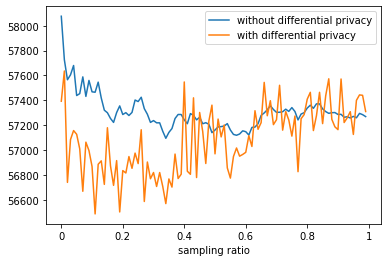

In [15]:
plt.plot(vanila_results, label="without differential privacy")
plt.plot(dp_results, label="with differential privacy")
plt.xticks([0, 20, 40, 60, 80, 100], [0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xlabel("sampling ratio")
plt.legend()
plt.show()

## Attack 2. Identifying unique person

You want to know the annual income of your friend, Eljian Mitchell. You already know that he bought ProductKey = 606 on 6/27/2017. 
It means that if the number of records whose ProductKey = 606 and OrderDate = 6/27/2017 is one, you can get his annual income with a mean query.  

In [17]:
df_sales_2015 = pd.read_csv("data/AdventureWorks-Sales-2015.csv")
df_sales_2015.head()

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity
0,01-01-2015,9/21/2001,SO45080,332,14657,1,1,1
1,01-01-2015,12-05-2001,SO45079,312,29255,4,1,1
2,01-01-2015,10/29/2001,SO45082,350,11455,9,1,1
3,01-01-2015,11/16/2001,SO45081,338,26782,6,1,1
4,01-02-2015,12/15/2001,SO45083,312,14947,10,1,1


In [18]:
df_sales_2017 = pd.read_csv("data/AdventureWorks-Sales-2017.csv")
df_sales_2017.head()

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity
0,01-01-2017,12/13/2003,SO61285,529,23791,1,2,2
1,01-01-2017,9/24/2003,SO61285,214,23791,1,3,1
2,01-01-2017,09-04-2003,SO61285,540,23791,1,1,1
3,01-01-2017,9/28/2003,SO61301,529,16747,1,2,2
4,01-01-2017,10/21/2003,SO61301,377,16747,1,1,1


In [19]:
df_sales = pd.concat([df_sales_2015, df_sales_2017])
df_sales.head()

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity
0,01-01-2015,9/21/2001,SO45080,332,14657,1,1,1
1,01-01-2015,12-05-2001,SO45079,312,29255,4,1,1
2,01-01-2015,10/29/2001,SO45082,350,11455,9,1,1
3,01-01-2015,11/16/2001,SO45081,338,26782,6,1,1
4,01-02-2015,12/15/2001,SO45083,312,14947,10,1,1


In [20]:
df_merged = pd.merge(df_sales, df_cus, on="CustomerKey")
df_merged.head()

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,Prefix,FirstName,LastName,BirthDate,MaritalStatus,Gender,EmailAddress,AnnualIncome,TotalChildren,EducationLevel,Occupation,HomeOwner
0,01-01-2015,9/21/2001,SO45080,332,14657,1,1,1,MR.,JOHN,THOMAS,11-11-1958,M,M,john48@adventure-works.com,80000,1,Partial College,Skilled Manual,N
1,01-09-2017,11/22/2003,SO61768,485,14657,1,2,2,MR.,JOHN,THOMAS,11-11-1958,M,M,john48@adventure-works.com,80000,1,Partial College,Skilled Manual,N
2,01-09-2017,12/20/2003,SO61768,215,14657,1,3,1,MR.,JOHN,THOMAS,11-11-1958,M,M,john48@adventure-works.com,80000,1,Partial College,Skilled Manual,N
3,01-09-2017,10-01-2003,SO61768,352,14657,1,1,1,MR.,JOHN,THOMAS,11-11-1958,M,M,john48@adventure-works.com,80000,1,Partial College,Skilled Manual,N
4,01-01-2015,12-05-2001,SO45079,312,29255,4,1,1,MR.,KYLE,WASHINGTON,04-11-1955,S,M,kyle8@adventure-works.com,80000,3,Partial College,Professional,N


query with differential privacy returns noised number, so the attacker can't say that the mean AnnualIncome is equal to his income. 

In [30]:
# Calculates number of records with specific productkey and orderdate without applying differential privacy.
def count_product_key_order_date(productkey : int, orderdate: str) -> int:
    return df_merged[(df_merged["ProductKey"] == productkey) &
                     (df_merged["OrderDate"] == orderdate)].count()[0]

def private_count_product_key_order_date(privacy_budget: float,
                                         productkey : int, orderdate: str) -> int:
    x = Count(privacy_budget, dtype="float")
    return x.quick_result(list(df_merged[(df_merged["ProductKey"] == productkey) &
                     (df_merged["OrderDate"] == orderdate)]["ProductKey"]))

target_productkey = 606
target_orderdate = "6/27/2017"
print(f"mean AnnualIncome (ProductKey = {target_productkey}, OrderDate = {target_orderdate}): ", 
     df_merged[(df_merged["ProductKey"] == 606) &
                     (df_merged["OrderDate"] == "6/27/2017")]["AnnualIncome"].mean())
print(f"true count (ProductKey = {target_productkey}, OrderDate = {target_orderdate}): ",
      count_product_key_order_date(target_productkey, target_orderdate))
print(f"count with differential privacy (ProductKey = {target_productkey}, OrderDate = {target_orderdate}): ",
      private_count_product_key_order_date(1, target_productkey, target_orderdate))

mean AnnualIncome (ProductKey = 606, OrderDate = 6/27/2017):  80000.0
true count (ProductKey = 606, OrderDate = 6/27/2017):  1
count with differential privacy (ProductKey = 606, OrderDate = 6/27/2017):  2
